In [117]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


In [118]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[..., 0::2] = torch.sin(position * div_term)
        pe[..., 1::2] = torch.cos(position * div_term)

        if batch_first:
            pe = pe.unsqueeze(0)
        else:
            pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        if self.batch_first:
            x = x + self.pe[:, :x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)



In [119]:
class TransformerModel(nn.Transformer):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken=6, ninp=512, nhead=8, nhid=2048, nlayers=6, dropout=0.5):
        super(TransformerModel, self).__init__(d_model=ninp, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, batch_first=True)
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout, batch_first=True)

        self.input_emb = nn.Linear(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, 1)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
        
        src = self.input_emb(src) # embedding
        src = self.pos_encoder(src)
        output = self.encoder(src, mask=self.src_mask) # transformer encoder
        output = self.decoder(output)
        
        return F.log_softmax(output, dim=-1)

In [120]:

torch.manual_seed(777)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
model = TransformerModel()

s = model(torch.rand(32, 25, 6), has_mask=False)
s.shape

torch.Size([32, 25, 1])

In [121]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

def default_splitter(folder_name, split=False):
    """This is a custom dataset class for time series data.
    Specifically, it is using the typical way to load all the data into memory and 
    return data and label in __getitem__ method.

    Args:
        file_name (_type_): _description_
        split (bool, optional): if split False, only two ways, 
                                otherwise 3 ways. Defaults to False.

    Returns:
        [Datasets]: _description_
    """
    file_names = []
    for file in os.listdir(folder_name):
        if os.path.isfile(os.path.join(folder_name, file)) and file.endswith('.csv'):
            file_names.append(file)
        else:
            print(f'{file} is not a csv file')
    # permute the order:
    file_names = np.random.permutation(file_names)
    
    if split:
        train_file_names = file_names[:int(len(file_names)*0.8)]
        val_file_names = file_names[int(len(file_names)*0.8):int(len(file_names)*0.9)]
        test_file_names = file_names[int(len(file_names)*0.9):]
        return DefaultDataset(train_file_names), DefaultDataset(val_file_names), DefaultDataset(test_file_names)
    else:
        # 2 ways split
        train_file_names = file_names[:int(len(file_names)*0.8)]
        test_file_names = file_names[int(len(file_names)*0.8):]
        return DefaultDataset(train_file_names), DefaultDataset(test_file_names)

class sliding_windows(nn.Module):
    def __init__(self, total_length, width, step):
        # https://stackoverflow.com/questions/53972159/how-does-pytorchs-fold-and-unfold-work
        super(sliding_windows, self).__init__()
        self.total_length = total_length
        self.width = width
        self.step = step

    def forward(self, input_time_series, labels):
        input_transformed = torch.swapaxes(input_time_series.unfold(-2, size=self.width, step=self.step), -2, -1)
        # For labels, we only have one dimension, so we unfold along that dimension
        labels_transformed = labels.unfold(0, self.width, self.step)
        return input_transformed, labels_transformed

    def get_num_sliding_windows(self):
        return round((self.total_length - (self.width - self.step)) / self.step)

class DefaultDataset(Dataset):
    """
    This is a custom dataset class for time series data.
    Specifically, it is using the typical way to load all the data into memory and 
    return data and label in __getitem__ method.

    TODO: add standardscaler into it to scale the data
    Args:
        Dataset (_type_): _description_
    """
    def __init__(self, file_names):
        self.file_names = file_names
        self.x, self.y = self._load_all_data()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def _load_all_data(self):
        # load into memory and do sliding windows:
        sw = sliding_windows(50, 25, 20)
        # load data into numpy:
        x = []
        y = []
        for file in self.file_names:
            data = pd.read_csv(os.path.join(folder_name, file))
            data = data.values
            data = torch.from_numpy(data)[:, 1::].float()
            # create label length_0 = 0, length_-1 = 0, length_1:n-1 = 1
            label = torch.zeros(data.shape[0])
            label[1:-1] = 1
            # do sliding windows:
            data, label = sw(data, label)
            # append to the list
            x.append(data)
            y.append(label)
        return torch.cat(x), torch.cat(y)
            
        
            
        
        
    

# Usage example
folder_name = './datasets/spar'
train_dataset, test_dataset = default_splitter(folder_name, split=False)
len(train_dataset)


.DS_Store is not a csv file


19250

Epoch 0, iter 800, loss 0.12891874730587005
Epoch 0, iter 1600, loss 0.12396249741315842
Epoch 0, iter 2400, loss 0.12393124759197235
Epoch 0, iter 3200, loss 0.12395624846220016
Epoch 0, iter 4000, loss 0.12390624701976777


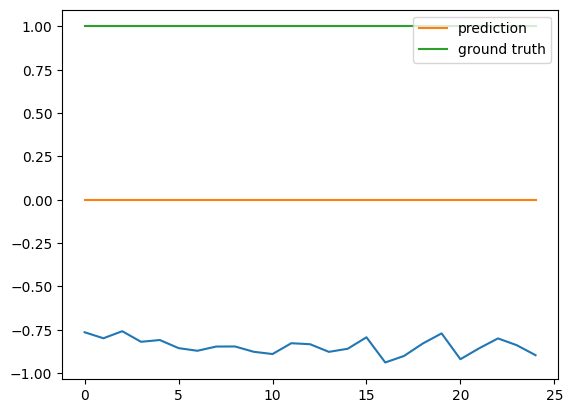

Epoch 0, iter 4800, loss 0.12396874725818634
Epoch 0, iter 5600, loss 0.1240249988436699
Epoch 0, iter 6400, loss 0.12397499769926071
Epoch 0, iter 7200, loss 0.12394999802112579
Epoch 0, iter 8000, loss 0.12395624816417694


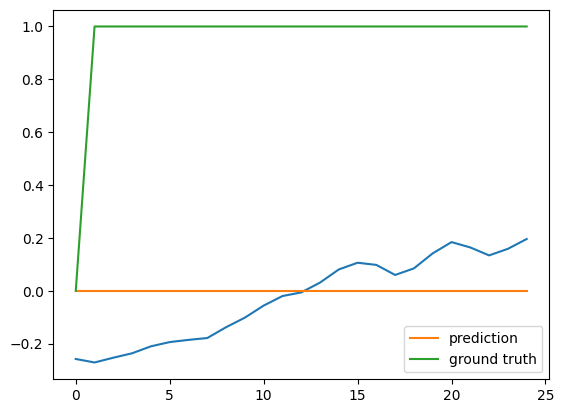

KeyboardInterrupt: 

In [129]:
import matplotlib.pyplot as plt
# train the transformer:
model = TransformerModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
# smooth l1 loss
criterion = nn.SmoothL1Loss()
plt.ion() # interactive mode
def train(model, train_dataset, optimizer, scheduler, criterion, device, batch_size=256, epochs=10):
    model.train()
    train_loss = 0
    for epoch in range(epochs):
        for i in range(0, len(train_dataset), batch_size):
            data, label = train_dataset[i:i+batch_size]
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data, has_mask=False).squeeze(-1)
            loss = criterion(output, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            train_loss += loss.item()
            if i % 100 == 0 and i > 0:
                cur_loss = train_loss / 100
                print(f'Epoch {epoch}, iter {i}, loss {cur_loss}')
                train_loss = 0
            if i % 1000 ==  0 and i > 0:
                # visualize a input and output pair in one batch[0]:
                plt.plot(data[0, :, 0].cpu().detach().numpy())
                plt.plot(output[0, :].cpu().detach().numpy(), label='prediction')
                plt.plot(label[0, :].cpu().detach().numpy(), label='ground truth')
                plt.legend()
                plt.show()
        
        scheduler.step()
    return model

model = train(model, train_dataset, optimizer, scheduler, criterion, device, batch_size=32, epochs=10)
